# Reproducibility with original data (seqFISH)

This tutorial demonstrates how to pseudo-spatiotemporal analysis on seqFISH mouse embryo data using Pysodb and SpaceFlow.

A reference paper can be found at https://www.nature.com/articles/s41467-022-31739-w.

This tutorial refers to the following tutorial at https://github.com/hongleir/SpaceFlow/blob/master/tutorials/seqfish_mouse_embryogenesis.ipynb. At the same time, the way of loadding data is modified by using Pysodb.

## Import packages and set configurations

In [1]:
# Use the Python warnings module to filter and ignore any warnings that may occur in the program after this point.
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import several python packages commonly used in data analysis and visualization.
# numpy (imported as np) is a package for numerical computing with arrays.
import numpy as np
# scanpy (imported as sc) is a package for single-cell RNA sequencing analysis.
import scanpy as sc
# matplotlib.pyplot (imported as plt) is a package for data visualization.
#import matplotlib.pyplot as plt

In [3]:
# from SpaceFlow package import SpaceFlow module
from SpaceFlow import SpaceFlow

In [4]:
# Imports a palettable package
import palettable
# Create three variables with lists of colors for categorical visualizations and biotechnology-related visualizations, respectively.
cmp_pspace = palettable.cartocolors.diverging.TealRose_7.mpl_colormap
cmp_domain = palettable.cartocolors.qualitative.Pastel_10.mpl_colors
cmp_ct = palettable.cartocolors.qualitative.Safe_10.mpl_colors

## Streamline development of loading spatial data with Pysodb

In [5]:
# Import pysodb package
# Pysodb is a Python package that provides a set of tools for working with SODB databases. 
# SODB is a format used to store data in memory-mapped files for efficient access and querying. 
# This package allows users to interact with SODB files using Python.
import pysodb

In [6]:
# Initialize the sodb object
sodb = pysodb.SODB()

In [7]:
# Define names of the dataset_name and experiment_name
dataset_name = 'lohoff2021integration'
experiment_name = 'lohoff2020highly_seqFISH_mouse_Gastrulation'
# Load a specific experiment
# It takes two arguments: the name of the dataset and the name of the experiment to load.
# Two arguments are available at https://gene.ai.tencent.com/SpatialOmics/.
#%%time
adata = sodb.load_experiment(dataset_name,experiment_name)

load experiment[lohoff2020highly_seqFISH_mouse_Gastrulation] in dataset[lohoff2021integration]


In [8]:
# Filter out genes
sc.pp.filter_genes(adata, min_cells=3)

## Perform SpaceFlow for pseudo-spatiotemporal analysis

In [9]:
# Create SpaceFlow Object
#%%time
sf = SpaceFlow.SpaceFlow(
    count_matrix=adata.X, 
    spatial_locs=adata.obsm['spatial'], 
    sample_names=adata.obs_names, 
    gene_names=adata.var_names
)

In [10]:
# Preprocess data
#%%time
sf.preprocessing_data(n_top_genes=3000)

In [11]:
# Train a deep graph network model
#%%time
sf.train(
    spatial_regularization_strength=0.1, 
    z_dim=50, 
    lr=1e-3, 
    epochs=1000, 
    max_patience=50, 
    min_stop=100, 
    random_seed=42, 
    gpu=0, 
    regularization_acceleration=True, 
    edge_subset_sz=1000000
)



Epoch 2/1000, Loss: 1.4433507919311523
Epoch 12/1000, Loss: 1.1957048177719116
Epoch 22/1000, Loss: 0.899651050567627
Epoch 32/1000, Loss: 0.5220355987548828
Epoch 42/1000, Loss: 0.25792792439460754
Epoch 52/1000, Loss: 0.15247754752635956
Epoch 62/1000, Loss: 0.11323283612728119
Epoch 72/1000, Loss: 0.09924617409706116
Epoch 82/1000, Loss: 0.08421587944030762
Epoch 92/1000, Loss: 0.08441664278507233
Epoch 102/1000, Loss: 0.07488397508859634
Epoch 112/1000, Loss: 0.07958334684371948
Epoch 122/1000, Loss: 0.07067480683326721
Epoch 132/1000, Loss: 0.07085031270980835
Epoch 142/1000, Loss: 0.06988634169101715
Epoch 152/1000, Loss: 0.06983151286840439
Epoch 162/1000, Loss: 0.07103468477725983
Epoch 172/1000, Loss: 0.06584274768829346
Epoch 182/1000, Loss: 0.06390106678009033
Epoch 192/1000, Loss: 0.06413406133651733
Epoch 202/1000, Loss: 0.06146261841058731
Epoch 212/1000, Loss: 0.06414571404457092
Epoch 222/1000, Loss: 0.06728968769311905
Epoch 232/1000, Loss: 0.0630531907081604
Epoch 242

array([[-0.5202136 , -0.17956705,  0.7582989 , ..., -0.1178573 ,
        -0.00734187,  2.4900703 ],
       [-0.46302137, -0.19299765,  1.0326352 , ..., -0.19934863,
        -0.06319354,  2.3966684 ],
       [-0.5225591 ,  0.6163565 ,  0.13151401, ..., -0.03753699,
        -0.00742718,  2.095408  ],
       ...,
       [-0.23238094,  0.99448997, -0.00804079, ..., -0.03581214,
         0.579624  ,  1.5177417 ],
       [-0.32503372, -0.07396829,  1.0361072 , ..., -0.13758945,
         0.98967546,  2.352452  ],
       [-0.21778385,  0.82494813,  0.03623015, ..., -0.06693349,
         0.8934428 ,  1.5172613 ]], dtype=float32)

In [12]:
# Idenfify the spatiotemporal patterns through pseudo-Spatiotemporal Map (pSM)
sf.pseudo_Spatiotemporal_Map(pSM_values_save_filepath="./pSM_values.tsv", n_neighbors=20, resolution=1.0)

Performing pseudo-Spatiotemporal Map
pseudo-Spatiotemporal Map(pSM) calculation complete, pSM values of cells or spots saved at ./pSM_values.tsv!


In [13]:
# Create a new column called 'pspace' from pSM values of cells or spots.
adata.obs['pspace'] = sf.pSM_values

(-2.802851333716996,
 2.7737768053548297,
 -3.8412926523589537,
 3.841292652358961)

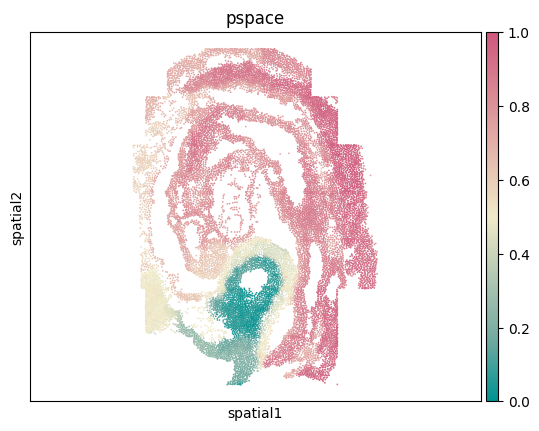

In [14]:
# Visualize spatial coordinates in a scatterplot colored by 'pspace'
ax = sc.pl.embedding(adata,basis='spatial',color='pspace',show=False,color_map=cmp_pspace)
ax.axis('equal')
#plt.savefig('figures/seqFISH_pspace.png',bbox_inches='tight',transparent=True,dpi=400)
#plt.savefig('figures/seqFISH_pspace.pdf',bbox_inches='tight',transparent=True,dpi=400)

(-2.802851333716996,
 2.7737768053548297,
 -3.8412926523589537,
 3.841292652358961)

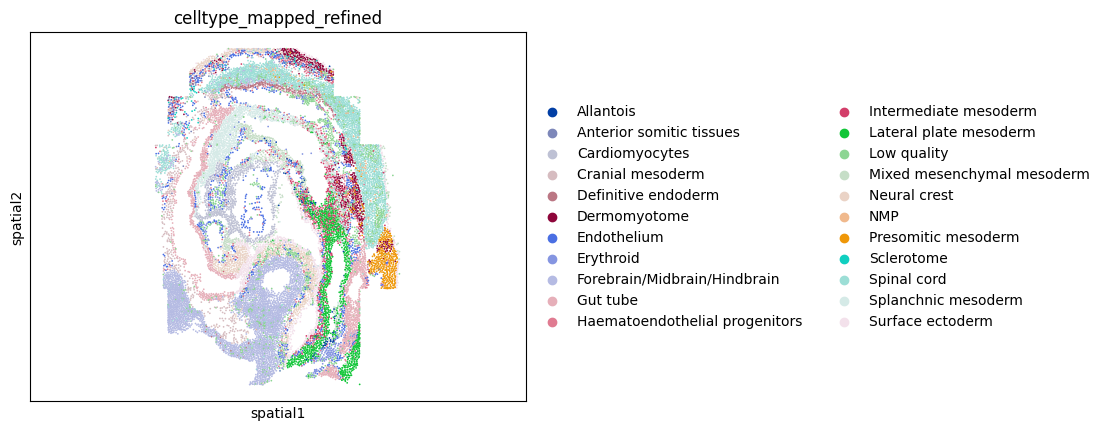

In [15]:
# Visualize spatial coordinates in a scatterplot colored by 'celltype_mapped_refined'
ax = sc.pl.embedding(adata,basis='spatial',color='celltype_mapped_refined',show=False)
ax.axis('equal')
#plt.savefig('figures/seqFISH_ct.png',bbox_inches='tight',transparent=True,dpi=400)
#plt.savefig('figures/seqFISH_ct.pdf',bbox_inches='tight',transparent=True,dpi=400)